# Imports

In [1]:
!pip install --upgrade cvxpy
!pip install mosek

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from sklearn import linear_model
from scipy.optimize import curve_fit
from scipy.optimize import nnls
import cvxpy as cp
import numpy as np
import scipy as sp
# import dykstra 
import matplotlib.pyplot as plt
# import pwlf
import matplotlib.animation as animation
from matplotlib import rc

rc('animation', html='jshtml')

In [3]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
! pip install jaxopt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Dynamic Fisher Market w/ linear Fitted Value Iteration

## Library

#### Utilities

In [4]:
################### Utility Functions ##########################

def get_linear_util(demands, valuations):
    util = np.sum(demands * valuations, axis = 1) 
    return util


def get_leontief_util(demands, valuations):
    util =  np.min(demands/valuations.clip(min = 0.001), axis = 1) 
    return util

def get_cd_util(demands, valuations):
    util = np.sum(np.log(demands.clip(min = 0.001))*valuations, axis = 1) 
    return util + 100


#################### Utility Gradient Functions #####################
def get_linear_util_gradient(allocations, valuations):
    return valuations

def get_leontief_util_gradient(allocations, valuations):
    grad_matrix = []
    argmins = np.argmin(allocations/valuations.clip(min = 0.001), axis = 0)
    marginal_utils = np.zeros(allocations.shape)
    
    for buyer in range(allocations.shape[0]):
      marginal_utils[buyer, argmins[buyer] ] = 1 / valuations[buyer, argmins[buyer]].clip(min = 0.001)
    
    return marginal_utils

def get_cd_util_gradient(allocations, valuations):
    # return ( np.prod(np.power(allocations, valuations), axis = 1)*( valuations / allocations.clip(min = 0.001) ).T).T
    return ( valuations / allocations.clip(min = 0.001) )
################### Projection Onto Budget Set ##########################


def project_onto_half_space(X, beta, p, b):
  offsets = ((X @ p + beta - b).clip(min= 0))/(np.linalg.norm(p)**2).clip(min= 10e-5)

  X_proj = X - (offsets*np.tile(p, reps = (b.shape[0], 1)).T).T
  beta_proj = beta - offsets
  
  return (X_proj, beta_proj)


def project_onto_positive_ortanth(X, beta, p, b):

  return (X.clip(min = 0), beta.clip(min = 0))

def project_to_bugdet_set(X, beta, p, b):
  iter = 0
  P_X, P_beta = np.zeros(X.shape), np.zeros(b.shape[0])
  Q_X, Q_beta = np.zeros(X.shape), np.zeros(b.shape[0])
  X_proj_y, beta_proj_y = X, beta
  X_proj_x, beta_proj_x = np.ones(X.shape), np.ones(b.shape[0])
  
  X_proj_prev, beta_proj_prev = X.copy(), beta.copy()
  change = float("inf")
  iter = 0
  while np.any(X_proj_x @ p + beta_proj_x - b >  10e-4) or np.any(X_proj_x < 0) or np.any(beta_proj_x < 0) :
  # while iter <= 1000:
    iter += 1
    # print("iterations", iter, "error: ", change)
    X, beta = project_onto_positive_ortanth(X, beta )
    X, beta = project_onto_half_space(X, beta )
    
    # print("proj", X_proj_x, beta_proj_x)
    P_X, P_beta = (P_X + X_proj_y - X_proj_x, P_beta + beta_proj_y - beta_proj_x)
    X_proj_y, beta_proj_y = project_onto_half_space(X_proj_x + Q_X, beta_proj_x + Q_beta, p, b)
    Q_X, Q_beta = Q_X + X_proj_x - X_proj_y, Q_beta + beta_proj_x- beta_proj_y
    
    change = np.linalg.norm(X_proj_prev - X_proj_x) + np.linalg.norm(beta_proj_prev - beta_proj_x)
    X_proj_prev, beta_proj_prev = X_proj_x.copy(), beta_proj_x.copy()
  
  assert np.all(X_proj_x @ p + beta_proj_x - b <=  10e-2) and np.all(X_proj_x >= 0) and np.all(beta_proj_x >= 0) 
  # print("proj", X_proj_x, beta_proj_x)
  return X_proj_x, beta_proj_x
  # shadow_demands = np.zeros((X.shape[0], X.shape[1] + 1))
  # shadow_prices = np.zeros(X.shape[1] + 1)
  # shadow_demands[:, :-1] = X 
  # shadow_demands[:, -1] = beta

  # shadow_prices[:-1] = p
  # shadow_prices[-1] = 1
  
  # P, Q = np.zeros((X.shape[0], X.shape[1] + 1))
  # (1/np.linalg.norm(shadow_prices)**2).clip(min= 0.00000001)*((shadow_demands @ shadow_prices - b).clip(min= 0)* np.tile(shadow_prices, reps = (b.shape[0], 1)).T).T
  # while (np.linalg.norm((shadow_demands @   shadow_prices - b).clip(min = 0)) < 1):
      
  #     shadow_demands -= (1/np.linalg.norm(shadow_prices)**2).clip(min= 0.00000001)*((shadow_demands @ shadow_prices - b).clip(min= 0)* np.tile(shadow_prices, reps = (b.shape[0], 1)).T).T
  #     shadow_demands = shadow_demands.clip(min = 0)
      
  
  
  # return (shadow_demands[:, :-1], shadow_demands[:, -1])

################### Min-Max Objective Functions ##########################

def get_linear_obj(prices, demands, budgets, valuations):
  utils = np.sum(valuations * demands, axis = 1)
  return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


def get_leontief_obj(prices, demands, budgets, valuations):
    utils = np.min(demands/valuations, axis = 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


def get_cd_obj(prices, demands, budgets, valuations):
    utils = np.prod(np.power(demands, valuations), axis= 1)
    return np.sum(prices) + budgets @ np.log(utils.clip(min=0.0001))


################### Heuristic objective function ##########################
def get_global(X, get_obj, prices, budgets, valuations, value_coef, value_intercept):
  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  X = X.reshape((num_buyers, num_goods + 1))
  
  demands = X[:, :-1]
  savings = X[:, -1]
  demands = demands.clip(min = 0.0001)
  savings = savings.clip(min = 0.0001)
  
  return -(get_obj(prices, demands, budgets-savings, valuations) + discount*(value_coef.T @ savings + value_intercept) )

### Test JAX

In [5]:
from jax import device_put

demands = np.random.rand(2,2)
demand=demands[0]
demand = device_put(demand)
valuations = np.array([[21.26920423, 33.45640665],
 [45.06020981, 23.52635807]])
valuation = device_put(valuations[0])

#### Linear

In [6]:
def get_linear_obj(prices, demands, budgets, valuations):
  utils = jnp.sum(valuations * demands, axis = 1)
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils.clip(0.001)))

def get_linear_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  next_budgets = savings + jnp.array([9.5, 9.5])
  return get_linear_obj(prices, demands, budgets-savings, valuations) + discount*(next_budgets.T @ value_coef + value_intercept)

prices = device_put(np.array([10.0,10.0]))
demands = device_put(np.array([[2.0,2.1],[2.2,2.3]]))
budgets = device_put(np.array([10,10]))
savings = device_put(np.array([0.01,0.01]))
value_coef = device_put(np.repeat(0,2.0))
value_intercept = 10.0

print(get_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_linear_value = grad(jit(get_linear_value), argnums=1)
savings_grad_linear_value = grad(jit(get_linear_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_linear_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


spendings = budgets - savings
utils = get_linear_util(demands, valuations).clip(min = 0.01)
marginals = get_linear_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

126.47856
___________________JAX___________________
[[1.8837347 2.96311  ]
 [2.9374995 1.5336959]]
[-4.7255883 -5.0320253]
___________________BY HAND___________________
[[1.8837347 2.96311  ]
 [2.9374995 1.5336959]]
[-4.7255883 -5.0320253]


#### leontief

In [16]:
def get_leontief_obj(prices, demands, budgets, valuations):
  utils = jnp.min(demands/valuations, axis = 1) 
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils))

def get_leontief_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  next_budgets = savings + jnp.array([9.5, 9.5])
  return get_leontief_obj(prices, demands, budgets-savings, valuations) + discount*(next_budgets.T @ value_coef + value_intercept)

prices = device_put(np.array([10.0,10.0]))
demands = device_put(np.array([[0.25363,   0.01662551],
                              [0.8234044, 0.3926105]]))
budgets = device_put(np.array([10,10]))
savings = device_put(np.array([0.01,0.01]))
value_coef = device_put(np.array([-11, -2]))
value_intercept = 10.0

print(get_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_leontief_value = grad(jit(get_leontief_value), argnums=1)
savings_grad_leontief_value = grad(jit(get_leontief_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))

spendings = budgets - savings
utils = get_leontief_util(demands, valuations).clip(min = 0.01)
marginals = get_leontief_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)


-102.953094
___________________JAX___________________
[[  0.       600.8838  ]
 [  0.        25.445066]]
[-7.1076584 -2.5216606]
___________________BY HAND___________________
[[945.1888     0.      ]
 [ 13.285107   0.      ]]
[-7.1076584 -2.5216606]


In [8]:
def get_penalty(prices, demands, savings, budgets):
  excess_spendings = demands @ prices  + savings - budgets
  zeros = jnp.zeros(len(budgets))
  excess_spending = jnp.maximum(zeros, excess_spendings)

  return 1e10 * np.sum(excess_spending)

In [9]:
def get_leontief_value_penalty(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  next_budgets = savings + jnp.array([9.5, 9.5])
  return get_leontief_obj(prices, demands, budgets-savings, valuations) + discount*(next_budgets.T @ value_coef + value_intercept) - get_penalty(prices, demands, savings, budgets)

demands_grad_leontief_value = grad(jit(get_leontief_value_penalty), argnums=1)
savings_grad_leontief_value = grad(jit(get_leontief_value_penalty), argnums=2)
print("___________________JAX___________________")
print(demands_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_leontief_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))

___________________JAX___________________
[[ 0.000000e+00  6.008838e+02]
 [-1.000000e+11 -1.000000e+11]]
[-2.2929392e+00 -1.0000000e+10]


#### CD

In [10]:
def get_cd_obj(prices, demands, budgets, valuations):
  utils = jnp.sum(jnp.log(demands)*valuations, axis = 1) 
  return jnp.sum(prices) + jnp.dot(budgets, jnp.log(utils.clip(0.001)))

def get_cd_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept):
  next_budgets = savings + jnp.array([9.5, 9.5])
  return get_cd_obj(prices, demands, budgets-savings, valuations) + discount*(next_budgets.T @ value_coef + value_intercept)

prices = device_put(np.array([10.0,10.0]))
demands = device_put(np.array([[1.2,2],[0.31, 2.31]]))
budgets = device_put(np.array([10,10]))
savings = device_put(np.array([0.01,0.01]))
value_coef = device_put(np.repeat(0,2.0))
value_intercept = 10.0

print(get_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))


demands_grad_cd_value = grad(jit(get_cd_value), argnums=1)
savings_grad_cd_value = grad(jit(get_cd_value), argnums=2)
print("___________________JAX___________________")
print(demands_grad_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))
print(savings_grad_cd_value(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept))

spendings = budgets - savings
utils = get_cd_util(demands, valuations).clip(min = 0.01)
marginals = get_cd_util_gradient(demands, valuations)
demands_step = (((spendings/utils)*marginals.T)).T
savings_step = -np.log(utils) + 0.9*value_coef
print("___________________BY HAND___________________")
print(demands_step)
print(savings_step)

-7.0579185
___________________JAX___________________
[[6.5415177 6.173875 ]
 [0.        0.       ]]
[-3.298354   6.9077554]
___________________BY HAND___________________
[[ 1.3934748  1.3151594]
 [21.697891   1.520298 ]]
[-4.8447227 -4.2035522]


## Nested Gradient Descent Ascent based Solution

#### Min_Max step

##### Min_Max Step with JAX

In [11]:
def min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
                         num_iters_prices, num_iters_demands, utility_type, test=False):
  prices =np.zeros(valuations.shape[1]).clip(min = 10)
  # print(f"valuations: {valuations}")
  if utility_type == "linear":
      get_value = get_linear_value
      demands_grad = demands_grad_linear_value
      savings_grad = savings_grad_linear_value

  elif utility_type == "leontief":
      get_value = get_leontief_value
      demands_grad = demands_grad_leontief_value
      savings_grad = savings_grad_leontief_value

  elif utility_type == "cd":
      get_value = get_cd_value
      demands_grad = demands_grad_cd_value
      savings_grad = savings_grad_cd_value

  prices_step_sizes = []
  demands_step_sizes= []
  savings_step_sizes = []
      

  num_buyers = budgets.shape[0]
  num_goods = prices.shape[0]
  
  allocation = cp.Variable((num_buyers, num_goods))
  saving = cp.Variable(num_buyers)
  p = cp.Parameter(num_goods)
  b = cp.Parameter(num_buyers)  
  beta = cp.Parameter(num_buyers) 
  X = cp.Parameter((num_buyers, num_goods))

  # obj = cp.Minimize( cp.sum(cp.power(cp.norm(X - allocation, axis = 1), 2)) + cp.sum(cp.power(saving - beta, 2)))
  obj = cp.Minimize( cp.sum(cp.power(cp.norm(X - allocation, axis = 1), 2)) + cp.power(cp.norm(saving - beta), 2))
  # obj = cp.Minimize( cp.sum(cp.norm(X - allocation, axis = 1)) + cp.norm(saving - beta, 2))
  constr = [allocation @ p  + saving <= b,
              allocation >= 0,
              saving >= 0] 
  
  
  # Gradient Descent loop
  for iter_outer in range(1, num_iters_prices):
    if not(iter_outer % 10):
      print(f"\n****Min-Max Price Iteration {iter_outer}****")
   
    demands = np.zeros((num_buyers, num_goods)).clip(min = 1.0)
    savings = np.zeros(num_buyers).clip(min = 0)
    # Gradient Ascent loop
  
    for iter_inner in range(1, num_iters_demands):
      spendings = budgets - savings
      
      # Demand step
      demands_step = demands_grad(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept)
      demands += (iter_inner** (-1/2)) * learn_rate_demands * demands_step
      demands_step_sizes.append(np.linalg.norm(demands_step))
      # demands += learn_rate_demands*demands_step
      
      # Saving step
      savings_step = savings_grad(prices, demands, savings, budgets, valuations, 0.9, value_coef, value_intercept)
      savings += (iter_inner** (-1/2)) * learn_rate_demands * savings_step
      savings_step_sizes.append(np.linalg.norm(savings_step))


      # Projection step
      p.value = prices
      b.value = budgets
      beta.value = np.array(savings)
      X.value = np.array(demands)

      problem = cp.Problem(obj, constr)
      result = problem.solve(solver=cp.MOSEK, warm_start=True)
      # print("problem status", problem.status)
      
      if (allocation.value is None):
        print("------------we got something wrong!!!----------------")
        print(f"utils: {utils}")
        print(f"obj: {result}")
        print(f"prices: {prices}")
        print(f"budgets:{budgets}")
        print(f"savings: {savings}")
        print(f"demands: {demands}")
      demands, savings = allocation.value, saving.value
      # demands, savings = project_to_bugdet_set(demands, savings, prices, budgets)
      # print(demands)

     

    assert np.all(demands @ prices + savings <= budgets + 1e-3)
    # print("before update prices:",prices)
    excess_demands = np.sum(demands, axis = 0) - np.ones(num_goods)
    if np.linalg.norm(excess_demands) < 1e-2:
      print("Early end! Excess demand norm:", np.linalg.norm(excess_demands))
      break
    
    # prices += (iter_outer**(-1/2))* learn_rate_prices * excess_demands
    prices +=  learn_rate_prices * excess_demands
    prices_step_sizes.append(np.linalg.norm(excess_demands))
    prices = np.clip(prices, a_min=0.001, a_max = None)
    if test:
      print(prices)
      # print(demands)
      # print("-----------------------------------------------------")

  next_budgets = savings + np.ones(num_buyers) * 9.5
  value = get_value(prices, demands, savings, budgets, valuations, discount, value_coef, value_intercept)
  print("------------------------------------------------------------------")
  print("budgets:", budgets)
  print("demands:", demands)
  print("savings:", savings)
  print("prices:", prices)
  print("value:", value)
  print("excess demands:", excess_demands)
  if test == False:
    return value, prices, demands, savings
  else:
    return prices_step_sizes, demands_step_sizes, savings_step_sizes

#### Test Min_Max Step

In [14]:
valuations = np.array([[21.26920423, 33.45640665],
 [45.06020981, 23.52635807]])

1.5
0.00065
[9.87150916 9.87121076]
[9.76086112 9.76031869]
[9.66595587 9.66521506]
[9.58484173 9.5839395 ]
[9.51573197 9.51469799]
[9.45701154 9.45587086]
[9.40723823 9.40601122]
[9.36513573 9.36384041]
[9.32958598 9.32823624]

****Min-Max Price Iteration 10****
[9.29961585 9.29822174]
[9.27438262 9.27295274]
[9.25316107 9.25170303]
[9.23533054 9.23385011]
[9.22036136 9.21886292]
[9.20780226 9.20629069]
Early end! Excess demand norm: 0.009933136839525717
------------------------------------------------------------------
budgets: [9.09845395 9.18667045]
demands: [[0.40668817 0.58151247]
 [0.58629198 0.41145979]]
savings: [5.68057131e-05 7.13761685e-05]
prices: [9.20780226 9.20629069]
value: 29.693546
excess demands: [-0.00701984 -0.00702773]


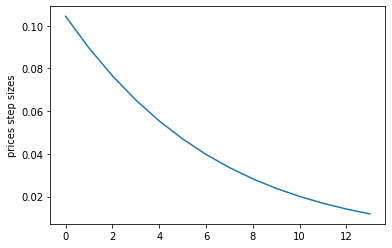

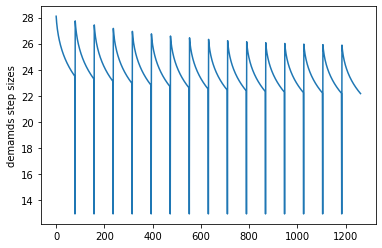

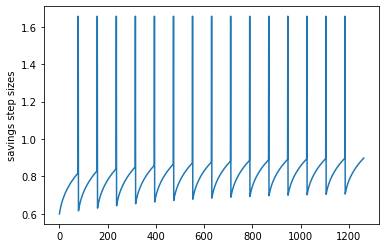

In [21]:
num_goods = 2
num_buyers = 2
num_samples = 25
discount = 0.9


valuations = np.array([[21.26920423, 33.45640665],
 [45.06020981, 23.52635807]])

valuations = valuations / (np.sum(valuations))


num_iters_prices = 60
num_iters_demands = 80

value_coef = np.zeros(2)
value_intercept = 0


budgets = np.array([9.09845395, 9.18667045])


utility_type = "leontief"


learn_rate_prices = 1.5
learn_rate_demands = 6.5e-4

print(learn_rate_prices)
print(learn_rate_demands)


prices_step_sizes, demands_step_sizes, savings_step_sizes = min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, 
                                                                                 discount, learn_rate_prices, learn_rate_demands, 
                                                                                num_iters_prices, num_iters_demands, utility_type, test=True)
plt.plot(prices_step_sizes[1:])
plt.ylabel("prices step sizes")
plt.show()

plt.plot(demands_step_sizes[1:])
plt.ylabel("demamds step sizes")
plt.show()

plt.plot(savings_step_sizes[1:])
plt.ylabel("savings step sizes")
plt.show()

In [ ]:
0.23064679292222323

#### Value Iteration

In [22]:
# The main function for value iteration
def fitted_linear_val_iter(valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands,
                                                                    num_iters_VI, num_iters_prices,  num_iters_demands, 
                                                                    num_samples, utility_type):
    coef_hist = [value_coef]
    intercept_hist = [value_intercept]
    values_hist = []
    budgets_hist = []
    
    num_buyers = valuations.shape[0]
    num_goods = valuations.shape[1]

    budgets_samples = np.random.uniform(9, 10, (num_samples, num_buyers))
    for iter in range(num_iters_VI):
        print(f"----------Value Iteration {iter}------------")
        values = []
        
        for index, budgets in enumerate(budgets_samples): 
            print(f"_____Sample {index}_____")
            value, prices, allocations, savings = min_max_linear_value_jax(budgets, valuations, value_coef, value_intercept, 
                                                                                   discount, learn_rate_prices, learn_rate_demands, 
                                                                                   num_iters_prices, num_iters_demands, utility_type)
            values.append(value)
        
        values = np.array(values)
        

        reg = linear_model.LinearRegression()
        reg.fit(budgets_samples, values)
        value_coef = reg.coef_ # Update the parameters
        value_intercept = reg.intercept_ # Update the intercept
        
        coef_hist.append(value_coef)
        intercept_hist.append(value_intercept)
        values_hist.append(values)
        budgets_hist.append(budgets_samples)

        print("value coef:", value_coef)
        print("value_intercept:", value_intercept)
        print("---------------------------------------------------------------------------------------------------------")

        # coef_hist_filename = f"/content/drive/My Drive/exp_results_{utility_type}_new_valfunc/coef_hist_{iter}_{utility_type}_fisher.npy"
        # intercept_hist_filename = f"/content/drive/My Drive/exp_results_{utility_type}_new_valfunc/intercept_hist_{iter}_{utility_type}_fisher.npy"
        # values_hist_filename = f"/content/drive/My Drive/exp_results_{utility_type}_new_valfunc/values_hist_{iter}_{utility_type}_fisher.npy"
        # budgets_hist_filename = f"/content/drive/My Drive/exp_results_{utility_type}_new_valfunc/budgets_hist_{iter}_{utility_type}_fisher.npy"
        # with open(coef_hist_filename, 'wb') as f:
        #     np.save(f, coef_hist)

        # with open(intercept_hist_filename, 'wb') as f:
        #     np.save(f, intercept_hist)

        # with open(values_hist_filename, 'wb') as f:
        #     np.save(f, values_hist)


        # with open(budgets_hist_filename, 'wb') as f:
        #     np.save(f, budgets_hist)

    return (coef_hist, intercept_hist, values_hist, budgets_hist)


### Experiments

In [24]:
from google.colab import drive
drive.mount('/content/drive')

num_goods = 2
num_buyers = 2
discount = 0.9
value_coef = np.repeat(1, num_buyers)
value_intercept = 0


valuations = np.array([[21.26920423, 33.45640665],
 [45.06020981, 23.52635807]])

valuations = valuations / np.sum(valuations)

real_learn_rate_prices = 1.5
real_learn_rate_demands = 6.5e-4

num_iters_VI = 30
num_iters_prices = 60 #10
num_iters_demands = 80 #20
num_samples = 15 #25



# coef_hist_linear, intercept_hist_linear, values_hist_linear, budgets_hist_linear = fitted_linear_val_iter(valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands,
#                                                                     num_iters_VI, num_iters_prices, num_iters_demands, 
#                                                                     num_samples, "leontief")

coef_hist_leontief, intercept_hist_leontief, values_hist_leontief, budgets_hist_leontief = fitted_linear_val_iter(valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands,
                                                                    num_iters_VI, num_iters_prices, num_iters_demands, 
                                                                    num_samples, "leontief")

# coef_hist_cd, intercept_hist_cd, values_hist_cd, budgets_hist_cd = fitted_linear_val_iter(valuations, value_coef, value_intercept, discount, learn_rate_prices, learn_rate_demands, 
#                                                                     num_iters_VI, num_iters_prices, num_iters_demands, 
#                                                                     num_samples, "cd")


Streaming output truncated to the last 5000 lines.
excess demands: [-0.00667647 -0.00656439]
_____Sample 4_____

****Min-Max Price Iteration 10****
Early end! Excess demand norm: 0.009035762807338156
------------------------------------------------------------------
budgets: [9.25583091 9.83728497]
demands: [[0.39081689 0.57261095]
 [0.60285949 0.42093484]]
savings: [0.0014243  0.00117664]
prices: [9.61144289 9.6016041 ]
value: 74.321625
excess demands: [-0.00632362 -0.00645421]
_____Sample 5_____
Early end! Excess demand norm: 0.009117083218262262
------------------------------------------------------------------
budgets: [9.98620296 9.54547472]
demands: [[0.4150542  0.60088897]
 [0.57838675 0.39277857]]
savings: [0.00108063 0.0016207 ]
prices: [9.82448473 9.83096357]
value: 75.24937
excess demands: [-0.00655905 -0.00633246]
_____Sample 6_____

****Min-Max Price Iteration 10****
Early end! Excess demand norm: 0.00949733105472033
--------------------------------------------------------

#### Save results

In [27]:
print(coef_hist_leontief)
print(intercept_hist_leontief)

[array([1, 1]), array([1.91717851, 1.61947765]), array([1.91761305, 1.61991242]), array([1.91760232, 1.61990222]), array([1.91761614, 1.61991371]), array([1.91761385, 1.61990776]), array([1.91760298, 1.61990469]), array([1.91760555, 1.61991419]), array([1.91761699, 1.61991722]), array([1.91762204, 1.61992106]), array([1.91761298, 1.61992694]), array([1.91762028, 1.61991224]), array([1.91761262, 1.61991045]), array([1.91761256, 1.61990761]), array([1.91760919, 1.61990327]), array([1.91761394, 1.6199205 ]), array([1.91760778, 1.61991896]), array([1.91760254, 1.61992309]), array([1.91758878, 1.61991626]), array([1.9175907 , 1.61990336]), array([1.91759657, 1.61988318]), array([1.91760426, 1.61989381]), array([1.91758952, 1.61988203]), array([1.9175972 , 1.61991017]), array([1.91759918, 1.61992153]), array([1.91759746, 1.61989563]), array([1.91762888, 1.61991696]), array([1.91760135, 1.61990329]), array([1.91759036, 1.61988847]), array([1.91759716, 1.61990579]), array([1.91760833, 1.619892

In [28]:
from google.colab import drive
drive.mount('/content/drive')


#### Save Linear data ##### 

# with open('/content/drive/My Drive/exp_results/jax_savings/coef_hist_linear_fisher.npy', 'wb') as f:
#     np.save(f, coef_hist_linear)

# with open('/content/drive/My Drive/exp_results/jax_savings/intercept_hist_linear_fisher.npy', 'wb') as f:
#     np.save(f, intercept_hist_linear)

# with open('/content/drive/My Drive/exp_results/jax_savings/values_hist_linear_fisher.npy', 'wb') as f:
#     np.save(f, values_hist_linear)

# with open('/content/drive/My Drive/exp_results/jax_savings/budgets_hist_linear_fisher.npy', 'wb') as f:
#     np.save(f, budgets_hist_linear)


# ##### Save Cobb-Douglas data #####
# with open('/content/drive/My Drive/exp_results_cd/coef_hist_cd_fisher.npy', 'wb') as f:
#     np.save(f, coef_hist_cd)

# with open('/content/drive/My Drive/exp_results_cd/intercept_hist_cd_fisher.npy', 'wb') as f:
#     np.save(f, intercept_hist_cd)

# with open('/content/drive/My Drive/exp_results_cd/values_hist_cd_fisher.npy', 'wb') as f:
#     np.save(f, values_hist_cd)

# with open('/content/drive/My Drive/exp_results/budgets_hist_cd_fisher.npy', 'wb') as f:
#     np.save(f, budgets_hist_cd)




##### Save Leontief data ##### 
with open('/content/drive/My Drive/exp_results/jax_savings/coef_hist_leontief_fisher.npy', 'wb') as f:
    np.save(f, coef_hist_leontief)

with open('/content/drive/My Drive/exp_results/jax_savings/intercept_hist_leontief_fisher.npy', 'wb') as f:
    np.save(f, intercept_hist_leontief)

with open('/content/drive/My Drive/exp_results/jax_savings/values_hist_leontief_fisher.npy', 'wb') as f:
    np.save(f, values_hist_leontief)

with open('/content/drive/My Drive/exp_results/jax_savings/budgets_hist_leontief_fisher.npy', 'wb') as f:
    np.save(f, budgets_hist_leontief)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
